In [1]:
import tensorflow as tf
import matplotlib.pylab as plt
import numpy as np

2023-12-08 12:42:15.214972: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-08 12:42:15.506454: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 12:42:15.506486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 12:42:15.556839: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 12:42:15.658850: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-12-08 12:42:18.351039: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 12:42:18.508327: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 12:42:18.508355: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Defining globals

In [3]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
EPOCHS = 30
class_names = ["chihuahua", "muffin"]

In [4]:
def predict_image(model, name, url):
    path = tf.keras.utils.get_file(name, origin=url)

    img = tf.keras.utils.load_img(
        path, target_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    print("{} most likely belongs to {} with a {:.2f} percent confidence."
          .format(name, class_names[np.argmax(score)], 100 * np.max(score)))

def test_prediction(model):
    predict_image(model, "Red_Sunflower", "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg")
    predict_image(model, "Chihuahua", "https://www.purina.at/sites/default/files/styles/ttt_image_510/public/2021-02/BREED%20Hero%20Mobile_0140_chihuahua_smooth.jpg")
    predict_image(model, "Chocolate_Muffin", "https://img.chefkoch-cdn.de/rezepte/1692201277528566/bilder/1502355/crop-960x540/die-schnellsten-und-besten-muffins-ueberhaupt.jpg")
    predict_image(model, "Blueberry_Muffin", "https://upload.wikimedia.org/wikipedia/commons/8/8a/Muffin_NIH.jpg")

## Training-Test Split

In [5]:
train_dir = "./data"
batch_size = 32

training_data = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  labels='inferred',  
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)

validation_data = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  labels='inferred',  
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)

Found 5917 files belonging to 2 classes.
Using 4734 files for training.


2023-12-08 12:42:18.763951: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 12:42:18.764019: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 12:42:18.764036: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 12:42:19.190862: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 12:42:19.190898: I external/local_xla/xla/stream_executor

Found 5917 files belonging to 2 classes.
Using 1183 files for validation.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

training_data = training_data.cache().shuffle(6000).prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)

## Running a pretrained model

In [7]:
base_model = tf.keras.applications.resnet_v2.ResNet50V2(
        include_top=False,
        pooling='max',
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        weights='imagenet')

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(512, 'relu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(2, 'softmax')
])

base_model.trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
Total params: 24745730 (94.40 MB)
Trainable params: 1180930 (4.50 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


### Preprocessing

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [9]:
data_preprocessing = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Resizing(IMG_HEIGHT, IMG_WIDTH),
])

In [10]:
model = tf.keras.Sequential([
  data_preprocessing,
  data_augmentation,
  #tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  #tf.keras.layers.MaxPooling2D(),
  model
])

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [12]:
history = model.fit(
  training_data,
  validation_data=validation_data,
  epochs=EPOCHS
)

Epoch 1/30


2023-12-08 12:42:26.804800: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-08 12:42:27.049880: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-08 12:42:30.394394: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa83527e3b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-08 12:42:30.394420: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2023-12-08 12:42:30.406200: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702035750.481317    1479 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


148/148 [==============================] - 30s 142ms/step - loss: 0.3222 - accuracy: 0.9660 - val_loss: 0.1888 - val_accuracy: 0.9620
Epoch 2/30
148/148 [==============================] - 14s 97ms/step - loss: 0.0425 - accuracy: 0.9882 - val_loss: 0.1065 - val_accuracy: 0.9831
Epoch 3/30
148/148 [==============================] - 14s 96ms/step - loss: 0.0592 - accuracy: 0.9848 - val_loss: 0.0412 - val_accuracy: 0.9932
Epoch 4/30
148/148 [==============================] - 14s 94ms/step - loss: 0.0258 - accuracy: 0.9930 - val_loss: 0.0800 - val_accuracy: 0.9822
Epoch 5/30
148/148 [==============================] - 14s 93ms/step - loss: 0.0224 - accuracy: 0.9928 - val_loss: 0.0587 - val_accuracy: 0.9882
Epoch 6/30
148/148 [==============================] - 14s 93ms/step - loss: 0.0183 - accuracy: 0.9941 - val_loss: 0.0723 - val_accuracy: 0.9856
Epoch 7/30
148/148 [==============================] - 14s 94ms/step - loss: 0.0304 - accuracy: 0.9896 - val_loss: 0.0580 - val_accuracy: 0.9899
Ep

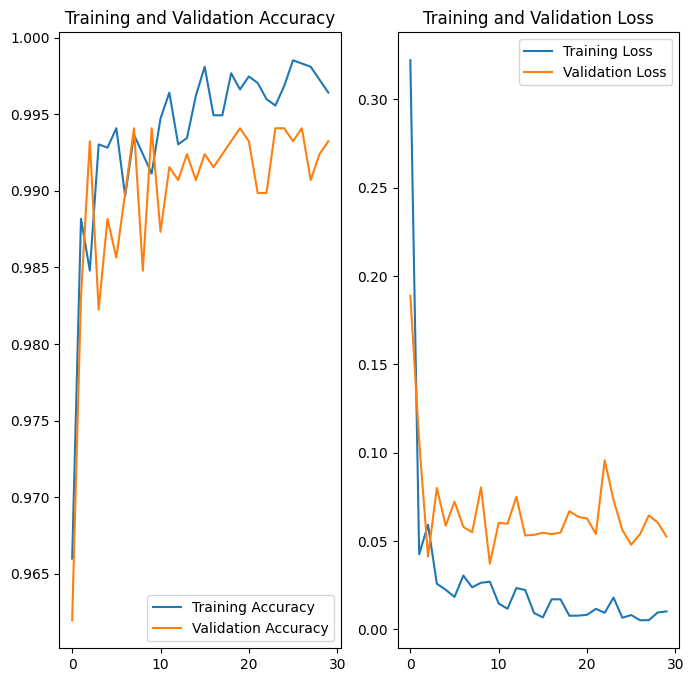

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
test_prediction(model)

1/1 [==============================] - 2s 2s/step
Red_Sunflower most likely belongs to muffin with a 72.86 percent confidence.
1/1 [==============================] - 0s 16ms/step
Chihuahua most likely belongs to chihuahua with a 73.11 percent confidence.
1/1 [==============================] - 0s 18ms/step
Chocolate_Muffin most likely belongs to muffin with a 73.11 percent confidence.
1/1 [==============================] - 0s 15ms/step
Blueberry_Muffin most likely belongs to muffin with a 73.11 percent confidence.


## Experiment: Training a custom model yields better results

In [15]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    tf.keras.layers.Convolution2D(filters=16, kernel_size=(5,5)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    tf.keras.layers.Convolution2D(filters=32, kernel_size=(5,5)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    tf.keras.layers.Convolution2D(filters=64, kernel_size=(3,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    tf.keras.layers.Convolution2D(filters=128, kernel_size=(3,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    tf.keras.layers.Convolution2D(filters=256, kernel_size=(3,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    tf.keras.layers.Flatten(),
            
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 16)      1216      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 110, 110, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 32)      12832     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 53, 53, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 51, 51, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 25, 25, 64)       

In [16]:
model = tf.keras.Sequential([
  data_preprocessing,
  data_augmentation,
  #tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  #tf.keras.layers.MaxPooling2D(),
  model
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [18]:
history = model.fit(
  training_data,
  validation_data=validation_data,
  epochs=EPOCHS
)

Epoch 1/30
148/148 [==============================] - 12s 56ms/step - loss: 0.5359 - accuracy: 0.7459 - val_loss: 0.3988 - val_accuracy: 0.8335
Epoch 2/30
148/148 [==============================] - 5s 34ms/step - loss: 0.4439 - accuracy: 0.8063 - val_loss: 0.4029 - val_accuracy: 0.8301
Epoch 3/30
148/148 [==============================] - 5s 33ms/step - loss: 0.3892 - accuracy: 0.8403 - val_loss: 0.3476 - val_accuracy: 0.8571
Epoch 4/30
148/148 [==============================] - 5s 34ms/step - loss: 0.3889 - accuracy: 0.8407 - val_loss: 0.3786 - val_accuracy: 0.8580
Epoch 5/30
148/148 [==============================] - 5s 33ms/step - loss: 0.3824 - accuracy: 0.8424 - val_loss: 0.4143 - val_accuracy: 0.8047
Epoch 6/30
148/148 [==============================] - 5s 33ms/step - loss: 0.3512 - accuracy: 0.8538 - val_loss: 0.3419 - val_accuracy: 0.8724
Epoch 7/30
148/148 [==============================] - 5s 34ms/step - loss: 0.3703 - accuracy: 0.8477 - val_loss: 0.3751 - val_accuracy: 0.867

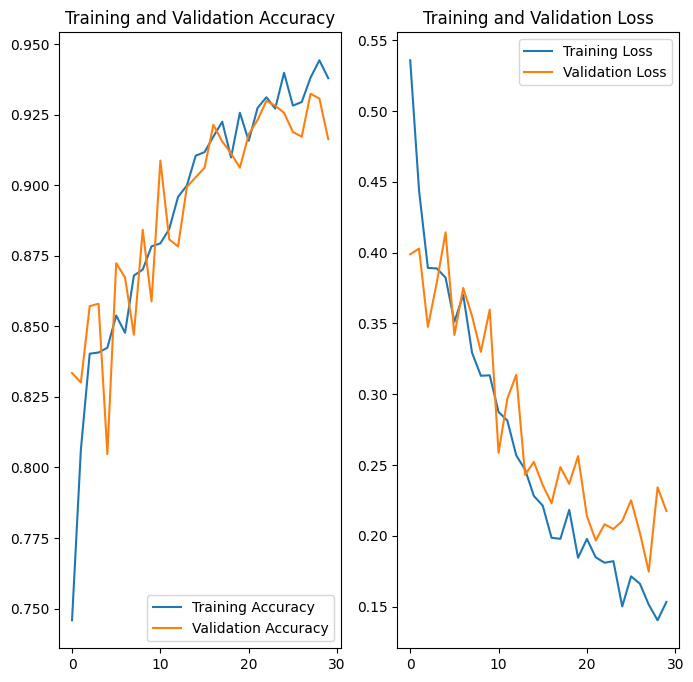

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
test_prediction(model)

1/1 [==============================] - 0s 365ms/step
Red_Sunflower most likely belongs to chihuahua with a 55.58 percent confidence.
1/1 [==============================] - 0s 11ms/step
Chihuahua most likely belongs to chihuahua with a 73.10 percent confidence.
1/1 [==============================] - 0s 15ms/step
Chocolate_Muffin most likely belongs to muffin with a 72.37 percent confidence.
1/1 [==============================] - 0s 13ms/step
Blueberry_Muffin most likely belongs to muffin with a 68.73 percent confidence.


## Results

The pretrained model detects with higher accuracy.